In [88]:
# Notebook Imports
from os import walk
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

%matplotlib inline

## constants

In [3]:
PATH = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.jason'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

FONT_FILE= 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'

# Reading Files

In [4]:
stream = open(PATH)
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [5]:
stream = open(PATH)
lines = []
is_body = False
for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True
        
stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

In [6]:
import sys
sys.getfilesystemencoding()

'utf-8'

## Generator Functions

In [7]:
def generate(N):
    for x in range(N):
        yield x ** 2
        
for i in generate(5):
    print(i, end = ' => ')

0 => 1 => 4 => 9 => 16 => 

# Email body Extraction

In [8]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            stream = open(filepath, encoding='latin-1')
            
            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body

In [9]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({"MESSAGE": email_body, "CATEGORY": classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [10]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))

In [11]:
spam_emails.shape

(1898, 2)

In [12]:
# DataFrame for the non spam Emails
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))

ham_emails.head()

MESSAGE  \
00001.7c53336b37003a9286aba55d2945844c      Date:        Wed, 21 Aug 2002 10:54:46 -05...   
00002.9c4069e25e1ef370c078db7ee85ff9ac  Martin A posted:\n\nTassos Papadopoulos, the G...   
00003.860e3c3cee1b42ead714c5c874fe25f7  Man Threatens Explosion In Moscow \n\n\n\nThur...   
00004.864220c5b6930b209cc287c361c99af1  Klez: The Virus That Won't Die\n\n \n\nAlready...   
00005.bf27cdeaf0b8c4647ecd61b1d09da613  >  in adding cream to spaghetti carbonara, whi...   

                                        CATEGORY  
00001.7c53336b37003a9286aba55d2945844c         0  
00002.9c4069e25e1ef370c078db7ee85ff9ac         0  
00003.860e3c3cee1b42ead714c5c874fe25f7         0  
00004.864220c5b6930b209cc287c361c99af1         0  
00005.bf27cdeaf0b8c4647ecd61b1d09da613         0

In [13]:
data = pd.concat([spam_emails, ham_emails])

print("Shape of entire DataFrame: ", data.shape)
data.head()

Shape of entire DataFrame:  (5799, 2)


MESSAGE  \
00001.7848dde101aa985090474a91ec93fcf0  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...   
00002.d94f1b97e48ed3b553b3508d116e6a09  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
00003.2ee33bc6eacdb11f38d052c44819ba6c  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
00004.eac8de8d759b7e74154f142194282724  ##############################################...   
00005.57696a39d7d84318ce497886896bf90d  I thought you might like these:\n\n1) Slim Dow...   

                                        CATEGORY  
00001.7848dde101aa985090474a91ec93fcf0         1  
00002.d94f1b97e48ed3b553b3508d116e6a09         1  
00003.2ee33bc6eacdb11f38d052c44819ba6c         1  
00004.eac8de8d759b7e74154f142194282724         1  
00005.57696a39d7d84318ce497886896bf90d         1

# Data Cleaning: Checking for missing Values

In [14]:
# Check if any Message Bodies are NULL
data["MESSAGE"].isnull().values.any()

False

In [15]:
# Check if there are empty emails (string lenght Zero)
(data["MESSAGE"].str.len() == 0).sum()

3

In [16]:
data.MESSAGE.isnull().sum()

0

## Locate Empty emails

In [17]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [18]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

## Removing system file entries from DataFrame

In [19]:
data = data.drop(['cmds'])

## Add document IDs to track Emails in Dataset

In [20]:
document_id = range(0, len(data.index))
data['DOC_ID'] = document_id
data["FILE_NAME"] = data.index

In [21]:
# Setting DOC_ID to INDEX
data.set_index('DOC_ID', inplace=True)

data.head()

MESSAGE  CATEGORY  \
DOC_ID                                                                
0       <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...         1   
1       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
2       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
3       ##############################################...         1   
4       I thought you might like these:\n\n1) Slim Dow...         1   

                                     FILE_NAME  
DOC_ID                                          
0       00001.7848dde101aa985090474a91ec93fcf0  
1       00002.d94f1b97e48ed3b553b3508d116e6a09  
2       00003.2ee33bc6eacdb11f38d052c44819ba6c  
3       00004.eac8de8d759b7e74154f142194282724  
4       00005.57696a39d7d84318ce497886896bf90d

In [22]:
data.tail()

MESSAGE  CATEGORY  \
DOC_ID                                                                
5791    http://news.bbc.co.uk/1/hi/england/2515127.stm...         0   
5792    > >-- be careful when using this one.) Also, t...         0   
5793    >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...         0   
5794    So then, "Mark Hammond" <mhammond@skippinet.co...         0   
5795    Hi there,\n\n\n\nNow this is probably of no us...         0   

                                     FILE_NAME  
DOC_ID                                          
5791    01396.61983fbe6ec43f55fd44e30fce24ffa6  
5792    01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7  
5793    01398.169b51731fe569f42169ae8f948ec676  
5794    01399.ca6b00b7b341bbde9a9ea3dd6a7bf896  
5795    01400.f897f0931e461e7b2e964d28e927c35e

## Save to file using Pandas

In [23]:
data.to_json(DATA_JSON_FILE)

## Number of spam messages visualized (Pie Chart)

In [24]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [25]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

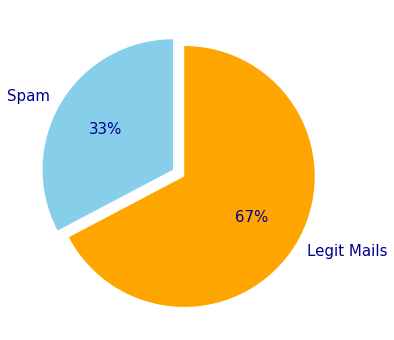

In [26]:
category_names = ['Spam', 'Legit Mails']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=[6, 6])
plt.style.use('default')
plt.pie(sizes, labels=category_names, textprops={'color':'darkblue', 'fontsize':15}, autopct='%1.0f%%', 
                                                startangle=90, explode=[0, 0.1], colors=['skyblue', 'orange'])

plt.show()

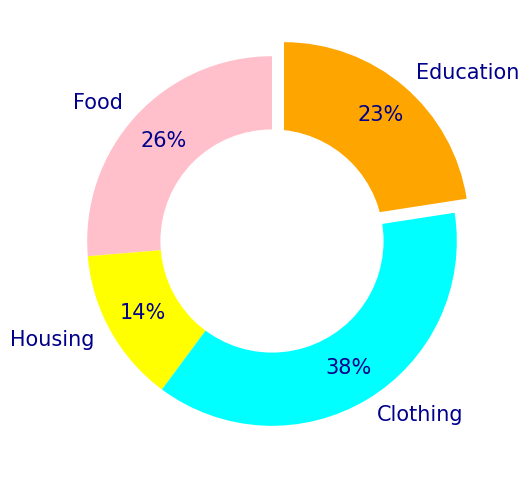

In [27]:
category_names = ['Food', 'Housing', 'Clothing', 'Education']
sizes = [35, 18, 50, 30]
colors = ['pink', 'yellow', 'cyan', 'orange']

plt.figure(figsize=[6, 6])
plt.style.use('default')
plt.pie(sizes, labels=category_names, textprops={'color':'darkblue', 'fontsize':15}, autopct='%1.0f%%', 
                                        startangle=90, colors=colors, pctdistance=0.8, explode=[0, 0, 0, 0.1])

circle = plt.Circle(xy=(0, 0), radius=0.6, color='white')
plt.gca().add_artist(circle)

plt.show()

# Natural Language Processing


### Text Pre-Processing

In [28]:
# Convert from upper to lowercase
msg = 'All work and No play makes Jack a Dull Boy'
msg.lower()

'all work and no play makes jack a dull boy'

## Download The NLTK Resources (Tokenizer & Stopwords)

In [29]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Engr
[nltk_data]     Shoayb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Engr
[nltk_data]     Shoayb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to C:\Users\Engr
[nltk_data]     Shoayb\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to C:\Users\Engr
[nltk_data]     Shoayb\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Tokenizing

In [32]:
msg = 'All work and No play makes Jack a Dull Boy'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

## Removing Stop words

In [33]:
stop_words = set(stopwords.words('english'))

In [34]:
if 'i' in stop_words: print("Found")

Found


In [35]:
msg = "All work and No Play makes Jack a dull boy. To be Or not to be."
words = word_tokenize(msg.lower())

filtered_words = []

for x in words:
    if x not in stop_words: filtered_words.append(x)
filtered_words

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']

# word Stems  and Stemming

In [36]:
msg = "All work and No Play makes Jacked a dull boy. To be Or not to be. ???"
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()

filtered_words = []

for word in words:
    if word not in stop_words: 
        stemed_word = stemmer.stem(word)
        filtered_words.append(stemed_word)    

filtered_words

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', '?', '?', '?']

## Removing Punctuation

In [37]:
msg = "All work and No Play makes Jacked a dull boy. To be Or not to be. ???"
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()

filtered_words = []

for word in words:
    if word not in stop_words and word.isalpha(): 
        stemed_word = stemmer.stem(word)
        filtered_words.append(stemed_word)    

filtered_words

['work', 'play', 'make', 'jack', 'dull', 'boy']

## Removing HTML tags from Emails

In [38]:
soup = BeautifulSoup(data.at[3, 'MESSAGE'], 'html.parser')

print(soup.prettify())

##################################################

#                                                #

#                 Adult Club                     #

#           Offers FREE Membership               #

#                                                #

##################################################



&gt;&gt;&gt;&gt;&gt;  INSTANT ACCESS TO ALL SITES NOW

&gt;&gt;&gt;&gt;&gt;  Your User Name And Password is.

&gt;&gt;&gt;&gt;&gt;  User Name: zzzz@spamassassin.taint.org

&gt;&gt;&gt;&gt;&gt;  Password: 760382



5 of the Best Adult Sites on the Internet for FREE!

---------------------------------------

NEWS 08/18/02

With just over 2.9 Million Members that signed up for FREE, Last month there were 721,184 New

Members. Are you one of them yet???

---------------------------------------

Our Membership FAQ



Q. Why are you offering free access to 5 adult membership sites for free?

A. I have advertisers that pay me for ad space so you don't have to pay for membership.



Q.

In [39]:
soup.get_text()

"##################################################\n\n#                                                #\n\n#                 Adult Club                     #\n\n#           Offers FREE Membership               #\n\n#                                                #\n\n##################################################\n\n\n\n>>>>>  INSTANT ACCESS TO ALL SITES NOW\n\n>>>>>  Your User Name And Password is.\n\n>>>>>  User Name: zzzz@spamassassin.taint.org\n\n>>>>>  Password: 760382\n\n\n\n5 of the Best Adult Sites on the Internet for FREE!\n\n---------------------------------------\n\nNEWS 08/18/02\n\nWith just over 2.9 Million Members that signed up for FREE, Last month there were 721,184 New\n\nMembers. Are you one of them yet???\n\n---------------------------------------\n\nOur Membership FAQ\n\n\n\nQ. Why are you offering free access to 5 adult membership sites for free?\n\nA. I have advertisers that pay me for ad space so you don't have to pay for membership.\n\n\n\nQ. Is it true m

# Function for Email Processing

In [40]:
def clean_message(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
    
    # convert to Lowercase and splits up the individual words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Remove Stop words and Punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [41]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [42]:
def clean_html_msg(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
    
    # Remove HTML Tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # convert to Lowercase and splits up the individual words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Remove Stop words and Punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            #filtered_words.append(word)
            
    
    return filtered_words

In [43]:
clean_html_msg(data.at[5, 'MESSAGE'])

['powerhous',
 'gift',
 'program',
 'want',
 'miss',
 'get',
 'founder',
 'major',
 'player',
 'one',
 'player',
 'privat',
 'invit',
 'expert',
 'call',
 'fastest',
 'way',
 'huge',
 'cash',
 'flow',
 'ever',
 'conceiv',
 'leverag',
 'question',
 'either',
 'want',
 'wealthi',
 'one',
 'toss',
 'financi',
 'lifelin',
 'sake',
 'hope',
 'grab',
 'onto',
 'hold',
 'tight',
 'ride',
 'life',
 'testimoni',
 'hear',
 'averag',
 'peopl',
 'first',
 'day',
 'receiv',
 'day',
 'al',
 'singl',
 'mother',
 'fl',
 'receiv',
 'last',
 'fl',
 'sure',
 'sent',
 'pledg',
 'got',
 'back',
 'next',
 'day',
 'ky',
 'money',
 'found',
 'partner',
 'work',
 'receiv',
 'last',
 'day',
 'think',
 'made',
 'right',
 'decis',
 'fl',
 'pick',
 'first',
 'day',
 'gave',
 'free',
 'lead',
 'train',
 'ca',
 'announc',
 'close',
 'sale',
 'help',
 'get',
 'fax',
 'blast',
 'immedi',
 'upon',
 'entri',
 'make',
 'money',
 'free',
 'lead',
 'train',
 'wait',
 'call',
 'fax',
 'back',
 'call',
 'best',
 'time',
 'me

# Applying cleaning and Tokenization to all messages


### Slicing DataFrames and Series & Creating subsets

In [44]:
data.iat[0, 1]

1

In [45]:
data.iloc[5:11]

MESSAGE  CATEGORY  \
DOC_ID                                                                
5       A POWERHOUSE GIFTING PROGRAM You Don't Want To...         1   
6       Help wanted.  We are a 14 year old fortune 500...         1   
7       <html>\n\n<head>\n\n<title>ReliaQuote - Save U...         1   
8       TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...         1   
9       Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...         1   
10      Cellular Phone Accessories All At Below Wholes...         1   

                                     FILE_NAME  
DOC_ID                                          
5       00006.5ab5620d3d7c6c0db76234556a16f6c1  
6       00007.d8521faf753ff9ee989122f6816f87d7  
7       00008.dfd941deb10f5eed78b1594b131c9266  
8       00009.027bf6e0b0c4ab34db3ce0ea4bf2edab  
9       00010.445affef4c70feec58f9198cfbc22997  
10      00011.61816b9ad167657773a427d890d0468e

In [46]:
data.MESSAGE.iloc[3:10]

DOC_ID
3    ##############################################...
4    I thought you might like these:\n\n1) Slim Dow...
5    A POWERHOUSE GIFTING PROGRAM You Don't Want To...
6    Help wanted.  We are a 14 year old fortune 500...
7    <html>\n\n<head>\n\n<title>ReliaQuote - Save U...
8    TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...
9    Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...
Name: MESSAGE, dtype: object

In [47]:
messages = data.MESSAGE.iloc[0:3]
messages

DOC_ID
0    <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...
1    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
2    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
Name: MESSAGE, dtype: object

In [48]:
# clean_messages = [clean_html_msg(message) for message in messages]

# # for message in messages:
# #     cleaned_message = clean_html_msg(message)
# #     clean_messages.append(cleaned_message)

nested_list = messages.apply(clean_html_msg)

In [49]:
nested_msg = messages.apply(clean_html_msg)

In [50]:
nested_msg

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
Name: MESSAGE, dtype: object

In [51]:
# nested_list = []
# for _list in nested_msg:
#     for new_list in _list:
#         nested_list.append(new_list)
        
# nested_list

flat_list = [item for _list in nested_msg for item in _list]
flat_list

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email',
 'fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'ch

In [52]:
%%time

# Aplly() in all the Email MESSAGES in the DataFrame
nested_list = data.MESSAGE.apply(clean_html_msg)

C:\Users\Engr Shoayb\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 2min 1s


In [53]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

# Using Logic to slice DataFrame

In [54]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [55]:
data[data.CATEGORY == 1].head()

MESSAGE  CATEGORY  \
DOC_ID                                                                
0       <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...         1   
1       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
2       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
3       ##############################################...         1   
4       I thought you might like these:\n\n1) Slim Dow...         1   

                                     FILE_NAME  
DOC_ID                                          
0       00001.7848dde101aa985090474a91ec93fcf0  
1       00002.d94f1b97e48ed3b553b3508d116e6a09  
2       00003.2ee33bc6eacdb11f38d052c44819ba6c  
3       00004.eac8de8d759b7e74154f142194282724  
4       00005.57696a39d7d84318ce497886896bf90d

In [56]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

doc_ids_spam, doc_ids_ham

(Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
             ...
             1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895],
            dtype='int64', name='DOC_ID', length=1896),
 Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
             ...
             5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
            dtype='int64', name='DOC_ID', length=3900))

# Subsetting a series with an Index

In [57]:
type(doc_ids_spam)

pandas.core.indexes.numeric.Int64Index

In [58]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_spam = nested_list.loc[doc_ids_spam]

In [59]:
nested_list_ham.head()

DOC_ID
1896    [date, wed, aug, chri, garrigu, ca, reproduc, ...
1897    [martin, post, tasso, papadopoulo, greek, scul...
1898    [man, threaten, explos, moscow, thursday, augu...
1899    [klez, viru, wo, die, alreadi, prolif, viru, e...
1900    [ad, cream, spaghetti, carbonara, effect, past...
Name: MESSAGE, dtype: object

In [60]:
list_spam_words = [word for words in nested_list_spam for word in words]

# Total Number of Unique Words in spam emails
spam_words = pd.Series(list_spam_words).value_counts()
spam_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

In [61]:
list_ham_words = [word for words in nested_list_ham for word in words]

# Total Number of Unique words in Normal Ennails
normal_words = pd.Series(list_ham_words).value_counts()
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

# Creating a Word Cloud

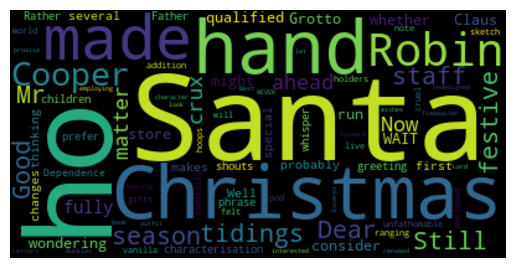

In [62]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='mitchell')
plt.axis('off')

plt.show()

In [63]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')

len(example_corpus)

260819

In [64]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [65]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word for word in word_list)

novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

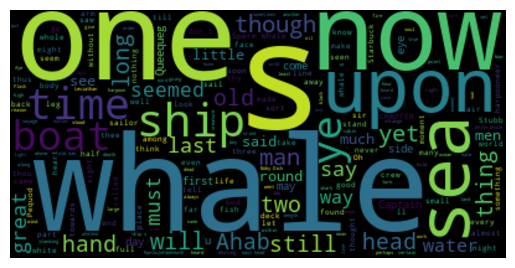

In [66]:
word_cloud = WordCloud().generate(novel_as_string)
plt.imshow(word_cloud, interpolation='mitchell')
plt.axis('off')

plt.show()

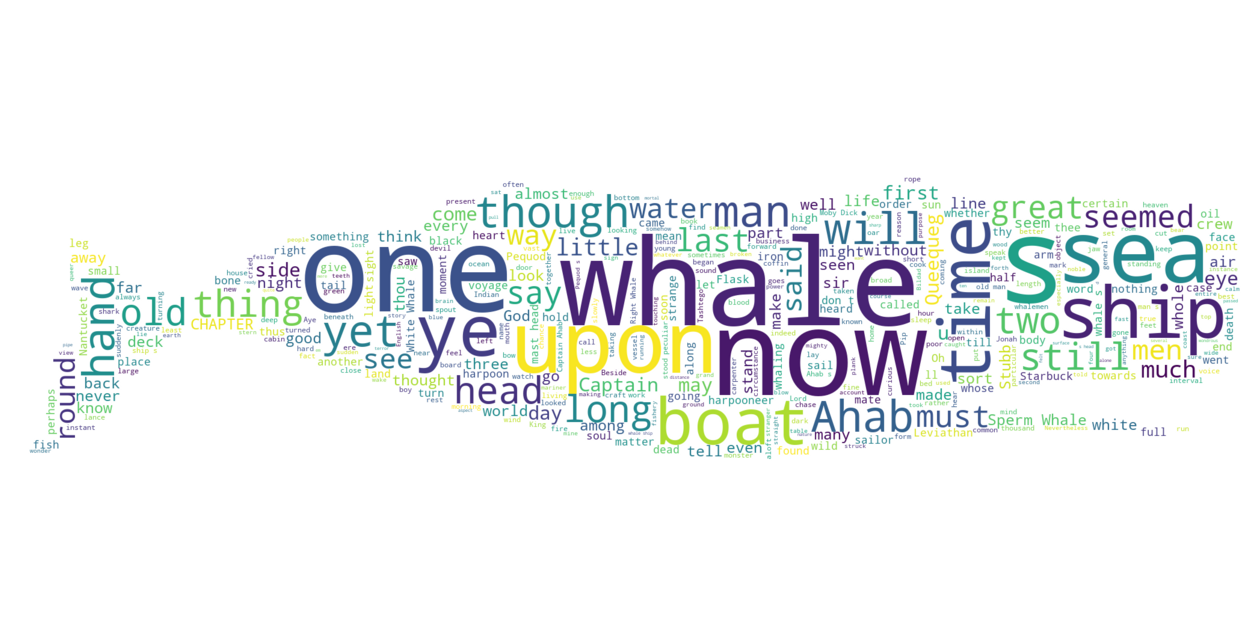

In [67]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_image = np.array(image_mask) # Converts Image to an nd-array

word_cloud = WordCloud(mask=rgb_image, background_color='white', max_words=400, repeat=True)
word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='mitchell')
plt.axis('off')

plt.show()

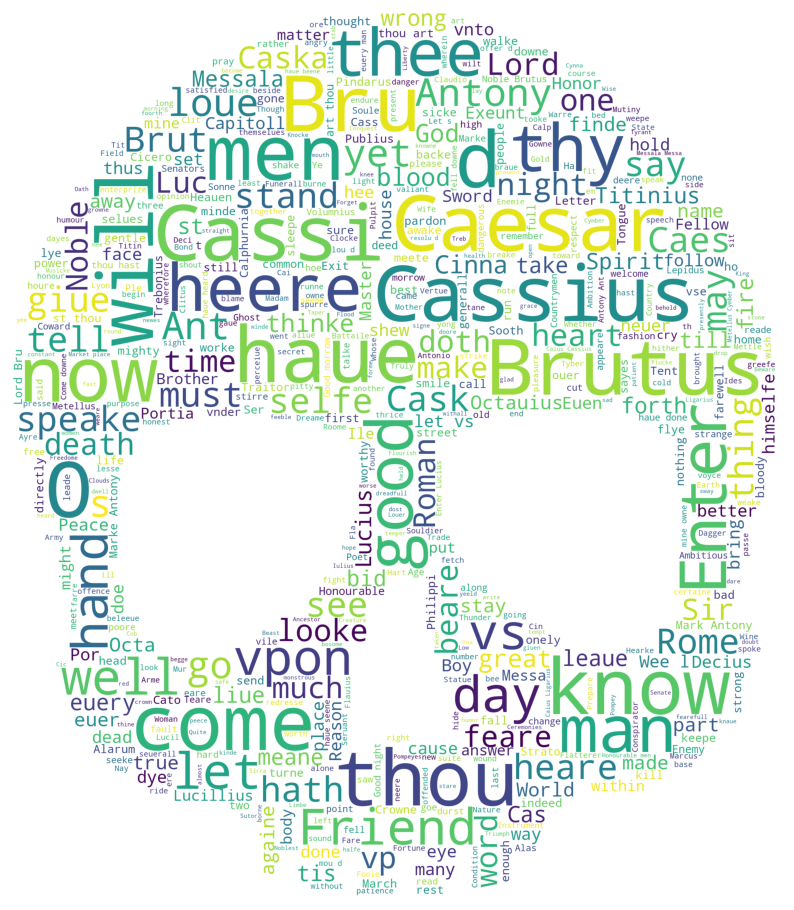

In [68]:
# Creating a Skull mask for Shakespear's play Hamlet 
example_2_corpus = nltk.corpus.gutenberg.words('shakespeare-caesar.txt')
caesar = [''.join(word) for word in example_2_corpus]
caesar_words = ' '.join(caesar)

skull_icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(255, 255, 255))
image_mask.paste(skull_icon, box=skull_icon)
rgb_skull = np.array(image_mask) # Convert Skull Image to Array


caesar_cloud = WordCloud(mask=rgb_skull, repeat=True, max_words=600, background_color='white').generate(caesar_words)

plt.figure(figsize=[10, 16])
plt.imshow(caesar_cloud)
plt.axis('off')
plt.show()

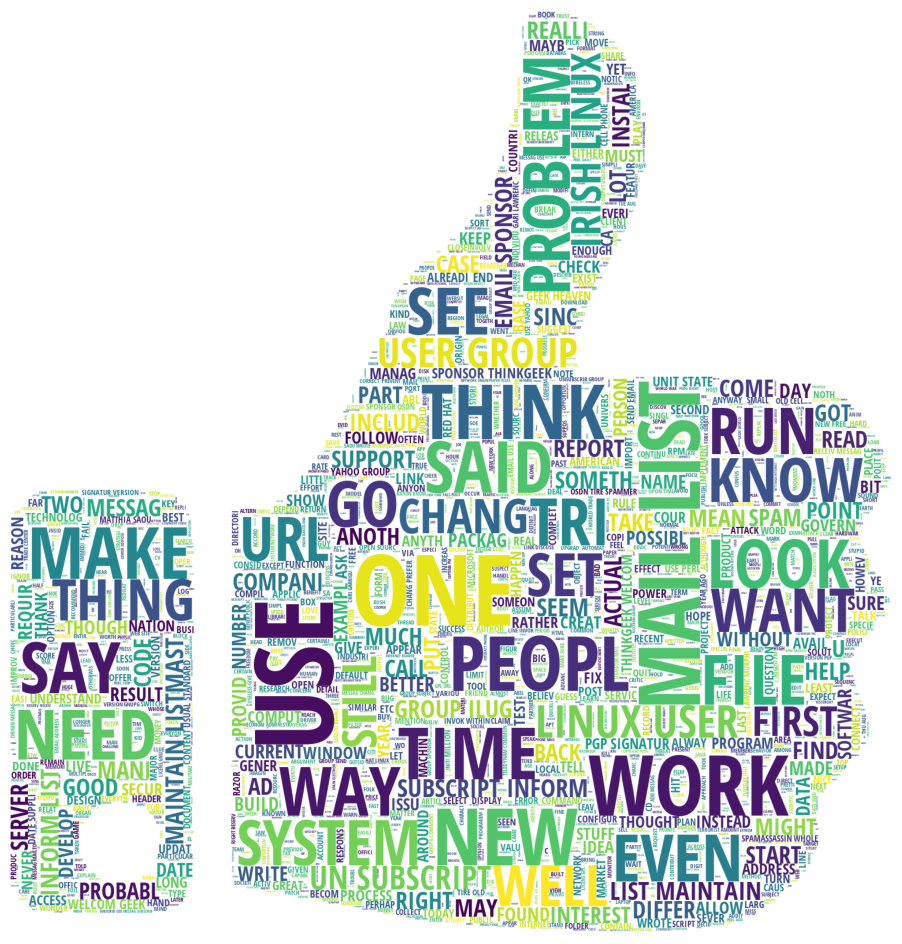

In [69]:
# Creating Thumbs up for Non Spam Messages
up_icon = Image.open(THUMBS_UP_FILE)
up_mask = Image.new(mode='RGB', size=up_icon.size, color=(255, 255, 255))
up_mask.paste(up_icon, box=up_icon)
rgb_thumb = np.array(up_mask)

ham_words = ' '.join(list_ham_words)
ham_cloud = WordCloud(font_path= FONT_FILE, mask=rgb_thumb, max_words=2000, 
                       background_color='white')
ham_cloud.generate(ham_words.upper())

plt.figure(figsize=[16, 12])
plt.imshow(ham_cloud)
plt.axis('off')
plt.show()

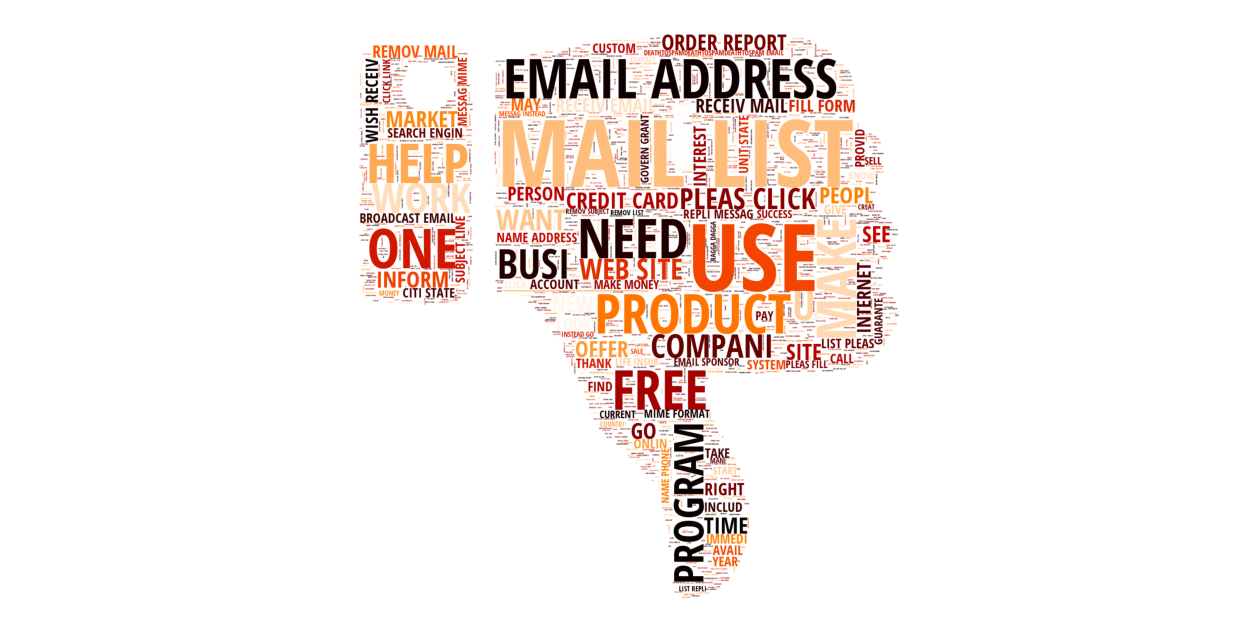

In [70]:
# Creating Thumbs Down for Spam Messages

up_icon = Image.open(THUMBS_DOWN_FILE)
up_mask = Image.new(mode='RGB', size=up_icon.size, color=(255, 255, 255))
up_mask.paste(up_icon, box=up_icon)
rgb_thumb = np.array(up_mask)

spam_words = ' '.join(list_spam_words)
spam_cloud = WordCloud(font_path= FONT_FILE, mask=rgb_thumb, repeat=True, max_words=2000, 
                       background_color='white', colormap='gist_heat')
spam_cloud.generate(spam_words.upper())

plt.figure(figsize=[16, 12])
plt.imshow(spam_cloud)
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary 

In [71]:
stemed_nested_list = data.MESSAGE.apply(clean_html_msg)
flat_stemed_list = [word for words in  stemed_nested_list for word in words]

C:\Users\Engr Shoayb\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [72]:
unique_words = pd.Series(flat_stemed_list).value_counts()
print('Number of Unique words:', unique_words.shape[0])
unique_words.head()

Number of Unique words: 27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [73]:
frequent_words = unique_words[0:VOCAB_SIZE]
print(f'MOST FREQUENT WORDS:\n{frequent_words[:10]}')

MOST FREQUENT WORDS:
http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


#  Create Vocabulary DataFrame with a WORD_ID

In [74]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame(data={'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'

vocab.head()

VOCAB_WORD
WORD_ID           
0             http
1              use
2             list
3            email
4              get

## Save the vocabulary to CSV file

In [75]:
vocab.to_csv(WORD_ID_FILE, index=vocab.index.name, header=vocab.VOCAB_WORD.name)

## Checking if a word is part of the Vocabulary

In [76]:
any(vocab.VOCAB_WORD == 'machine') # Inefficient

False

In [77]:
'machine' in set(vocab.VOCAB_WORD)  # Better Way

False

In [78]:
email = [len(email) for email in stemed_nested_list]

In [79]:
max(email)

7671

In [ ]:
stemed_nested_list[5775]

In [ ]:
data.at[np.argmax(email), 'MESSAGE']

# Generate Features and a Sparse Matrix 
## Creating a DataFrame with one word per column

In [92]:
word_columns_df = pd.DataFrame.from_records(stemed_nested_list.tolist())

word_columns_df.head()

0      1       2      3           4         5       6     7       8     \
0     save   life   insur  spend        life      quot    save     g  famili   
1    fight   risk  cancer   http        slim  guarante    lose    lb     day   
2    fight   risk  cancer   http        slim  guarante    lose    lb     day   
3    adult   club   offer   free  membership   instant  access  site    user   
4  thought  might    like   slim    guarante      lose      lb   day    http   

      9     ...  7661  7662  7663  7664  7665  7666  7667  7668  7669  7670  
0  financi  ...  None  None  None  None  None  None  None  None  None  None  
1     http  ...  None  None  None  None  None  None  None  None  None  None  
2     http  ...  None  None  None  None  None  None  None  None  None  None  
3     name  ...  None  None  None  None  None  None  None  None  None  None  
4    fight  ...  None  None  None  None  None  None  None  None  None  None  

[5 rows x 7671 columns]

In [93]:
word_columns_df.shape

(5796, 7671)

# Splitting the data into Training and Testing set

In [94]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size=0.3, random_state=42)

In [95]:
print('Number of Training Sample:', X_train.shape[0])
print('Fraction of Training Samples:', X_train.shape[0] / word_columns_df.shape[0])

Number of Training Sample: 4057
Fraction of Training Samples: 0.6999654934437544


In [96]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

0       1      2          3            4      5        6     \
DOC_ID                                                                   
4844         ye    inde  agent  directori       verita     cd     unix   
4727    problem    come    tri     instal  harddissssk   like  alreadi   
5022     origin  messag   date        mon          aug   chad  norwood   
3504      inlin    folk  sever      major     internet  outag     morn   
3921        url    http   date       bath     chronicl   None     None   

                7      8        9     ...  7661  7662  7663  7664  7665  7666  \
DOC_ID                                ...                                       
4844    subdirectori   file     call  ...  None  None  None  None  None  None   
4727           mount   http    yahoo  ...  None  None  None  None  None  None   
5022            sven     cc  subject  ...  None  None  None  None  None  None   
3504          across  major   provid  ...  None  None  None  None  None  None   
3921            None   None     None  ...  None  None  None  None  None  None   

        7667  7668  7669  7670  
DOC_ID                          
4844    None  None  None  None  
4727    None  None  None  None  
5022    None  None  None  None  
3504    None  None  None  None  
3921    None  None  None  None  

[5 rows x 7671 columns]

In [97]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

In [107]:
ee = pd.DataFrame.from_records(stemed_nested_list.tolist())
ee.shape

(5796, 7671)

In [99]:
stemed_nested_list

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

In [117]:
vocab.at[3, 'VOCAB_WORD']

'email'

In [126]:
word_idx = pd.Index(vocab.VOCAB_WORD)

In [127]:
word_idx.get_loc('thu')

392

In [131]:
y_train.at[4844]

0